<a href="https://colab.research.google.com/github/Emperor228/Titanic-Survival/blob/main/Titanic_Survival.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

Importing Data

In [2]:
df_train = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")

df_train.shape
df_test.shape

(418, 11)

Data pre processing

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
# Fonction de wrangling et feature engineering
def wrangling(df):
    # Supprimer les colonnes spécifiées
    df.drop(columns=["Cabin", "Ticket", "Name", "Embarked", "Fare"], axis=1, inplace=True)

    # Remplacer male et female par 0 et 1
    df.replace({"Sex": {"male": 0, "female": 1}}, inplace=True)

    # Remplacer les valeurs nan par la moyenne dans la colonne Age
    df["Age"].fillna(df["Age"].mean(), inplace=True)

    # Normaliser la colonne Age
    df['Age'] = (df['Age'] - df['Age'].min()) / (df['Age'].max() - df['Age'].min())

    # Feature Engineering: Ajouter une colonne FamilySize
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

    # Feature Engineering: Ajouter une colonne IsAlone
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    return df

# Apply the wrangling function and assign the result to df_train
df_train = wrangling(df_train)
df_train.drop(columns=['PassengerId'], inplace=True)
df_train.head()



,Survived,Pclass,Sex,Age,SibSp,Parch,FamilySize,IsAlone
0,0,3,0,0.271174,1,0,2,0
1,1,1,1,0.472229,1,0,2,0
2,1,3,1,0.321438,0,0,1,1
3,1,1,1,0.434531,1,0,2,0
4,0,3,0,0.434531,0,0,1,1


In [7]:
df_train['Pclass'].value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

Data Analysis

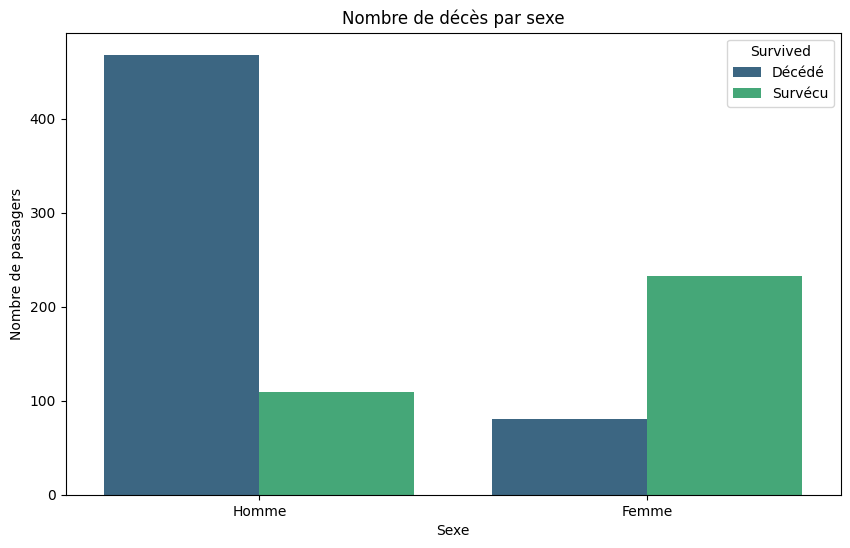

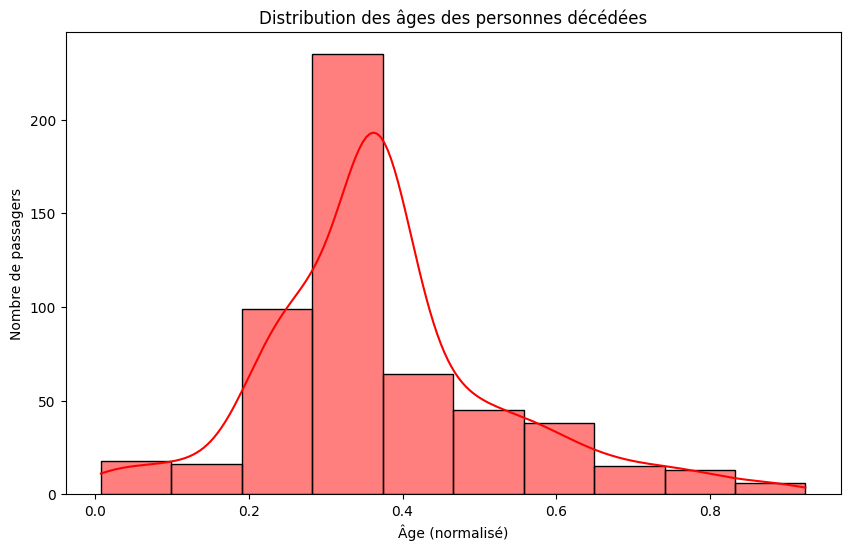

In [8]:
# Graphique du nombre de décès par sexe
plt.figure(figsize=(10, 6))
sns.countplot(x='Sex', hue='Survived', data=df_train, palette='viridis')
plt.title('Nombre de décès par sexe')
plt.xlabel('Sexe')
plt.ylabel('Nombre de passagers')
plt.legend(title='Survived', loc='upper right', labels=['Décédé', 'Survécu'])
plt.xticks(ticks=[0, 1], labels=['Homme', 'Femme'])
plt.show()

# Graphique du nombre de décès par tranche d'âge
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train[df_train['Survived'] == 0], x='Age', bins=10, kde=True, color='red')
plt.title('Distribution des âges des personnes décédées')
plt.xlabel('Âge (normalisé)')
plt.ylabel('Nombre de passagers')
plt.show()

Train Test Split

In [9]:
X = df_train.drop(columns="Survived", axis=1)
Y = df_train["Survived"]

In [10]:
print(X)

     Pclass  Sex       Age  SibSp  Parch  FamilySize  IsAlone
0         3    0  0.271174      1      0           2        0
1         1    1  0.472229      1      0           2        0
2         3    1  0.321438      0      0           1        1
3         1    1  0.434531      1      0           2        0
4         3    0  0.434531      0      0           1        1
..      ...  ...       ...    ...    ...         ...      ...
886       2    0  0.334004      0      0           1        1
887       1    1  0.233476      0      0           1        1
888       3    1  0.367921      1      2           4        0
889       1    0  0.321438      0      0           1        1
890       3    0  0.396833      0      0           1        1

[891 rows x 7 columns]


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=2)

# Normaliser les données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Définir une fonction pour construire le modèle avec hyperparamètres
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG', default=0.001)),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialiser le tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='titanic'
)

# Rechercher les meilleurs hyperparamètres
tuner.search(X_train, Y_train, epochs=100, validation_data=(X_test, Y_test), verbose=1)

# Obtenir les meilleurs hyperparamètres
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters: {best_hps.values}")



Reloading Tuner from my_dir/titanic/tuner0.json
Best hyperparameters: {'units_1': 320, 'dropout_1': 0.30000000000000004, 'units_2': 192, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.0005114665076835432}


Model Training

In [12]:
# Reconstruire le modèle avec les meilleurs hyperparamètres et réentraîner
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), verbose=1)

# Évaluer le modèle sur les données de test
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Accuracy with best hyperparameters: {accuracy:.4f}')



Epoch 1/100
23/23 [==============================] - 3s 38ms/step - loss: 0.5895 - accuracy: 0.7303 - val_loss: 0.5325 - val_accuracy: 0.7430
Epoch 2/100
23/23 [==============================] - 0s 10ms/step - loss: 0.4511 - accuracy: 0.8216 - val_loss: 0.4976 - val_accuracy: 0.7877
Epoch 3/100
23/23 [==============================] - 0s 15ms/step - loss: 0.4199 - accuracy: 0.8230 - val_loss: 0.5008 - val_accuracy: 0.7933
Epoch 4/100
23/23 [==============================] - 0s 19ms/step - loss: 0.4112 - accuracy: 0.8202 - val_loss: 0.4987 - val_accuracy: 0.7933
Epoch 5/100
23/23 [==============================] - 1s 29ms/step - loss: 0.4073 - accuracy: 0.8272 - val_loss: 0.4973 - val_accuracy: 0.7989
Epoch 6/100
23/23 [==============================] - 1s 25ms/step - loss: 0.4102 - accuracy: 0.8202 - val_loss: 0.5007 - val_accuracy: 0.7989
Epoch 7/100
23/23 [==============================] - 1s 24ms/step - loss: 0.4047 - accuracy: 0.8343 - val_loss: 0.4892 - val_accuracy: 0.7989
Epoch 

In [13]:
df_test = pd.read_csv("/content/test.csv")

# Sauvegarder les PassengerId avant de les supprimer
passenger_ids = df_test['PassengerId']

# Appliquer le wrangling sur les données de test
df_test = wrangling(df_test)

# Supprimer la colonne PassengerId
df_test.drop(columns=['PassengerId'], inplace=True)

# Normaliser les données de test
X_test_final = scaler.transform(df_test)

# Faire des prédictions sur les données de test
predictions = model.predict(X_test_final)
predictions = (predictions > 0.5).astype(int)

# Créer un DataFrame pour la soumission avec les PassengerId
submission = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': predictions.flatten()})

# Enregistrer le DataFrame dans un fichier CSV
submission.to_csv('submission.csv', index=False)

14/14 [==============================] - 0s 2ms/step
